<a href="https://colab.research.google.com/github/RH-Pronoy/BlackList/blob/main/wheat_densenet_121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas pillow



In [ ]:
!pip install pandas
!pip install opencv-python


In [ ]:
!pip install tensorflow==2.12.0
!pip install keras

INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 70.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 93.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 94.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 MB 22.0 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.0
    Uninst

In [ ]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
from tensorflow import keras
import glob as gb
import pandas as pd
from tensorflow.keras.preprocessing import image_dataset_from_directory
# Import RandomFlip and RandomRotation from the preprocessing module
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, LeakyReLU

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

IMG_SIZE = (299, 299) # resolution
directory = "/kaggle/input/wheat-leaf-diseases/Wheat Leaf Diseases Dataset From Bangladesh"
BATCH_SIZE = 128

train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             labels='inferred',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.1,
                                             subset='training',
                                             color_mode='rgb',
                                             seed=42)

validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             labels='inferred',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.1,
                                             subset='validation',
                                             color_mode='rgb',
                                             seed=42)


Found 3781 files belonging to 3 classes.
Using 3403 files for training.
Found 3781 files belonging to 3 classes.
Using 378 files for validation.


In [ ]:
class_names = train_dataset.class_names
class_names

['Wheat___Brown_Rust', 'Wheat___Healthy', 'Wheat___Yellow_Rust']

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


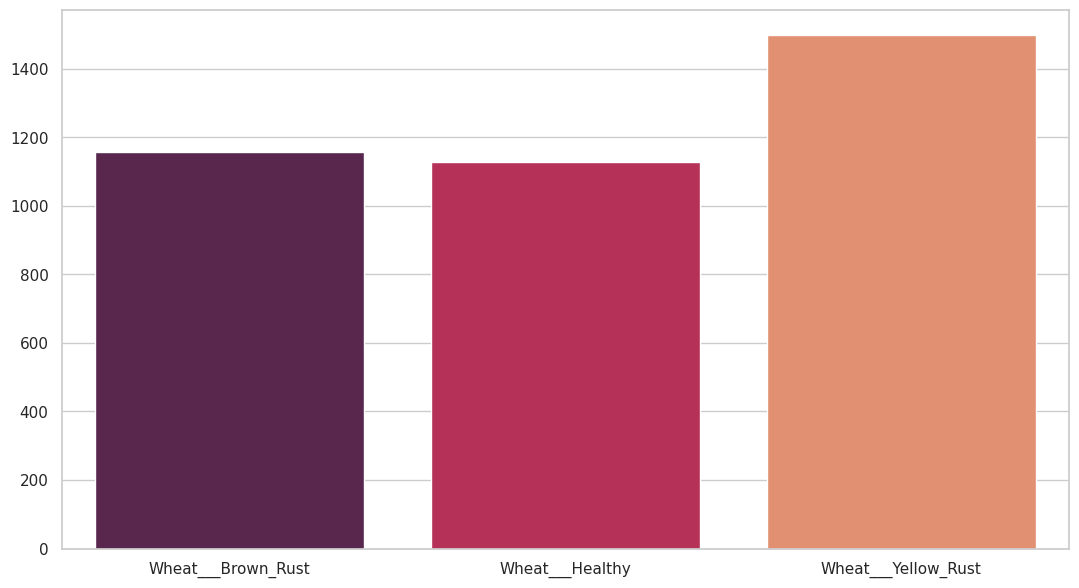

In [ ]:
sns.set_theme(style="whitegrid")
Data_imbalance = []
for folder in os.listdir(directory):
    files = gb.glob(pathname=str(directory + "/" + folder +"/*.*"))
    Data_imbalance.append(len(files))
plt.figure(figsize=(13,7))
sns.barplot(x=['Wheat___Brown_Rust', 'Wheat___Healthy', 'Wheat___Yellow_Rust'], y=Data_imbalance, palette="rocket")
plt.show()


In [ ]:
total = 0
for i in range(0,len(Data_imbalance)) :
    total +=Data_imbalance[i]

weight_for_0 = (1 / Data_imbalance[0]) * (total / 4.0)
weight_for_1 = (1 / Data_imbalance[1]) * (total / 4.0)
weight_for_2 = (1 / Data_imbalance[2]) * (total / 4.0)

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))


Weight for class 0: 0.82
Weight for class 1: 0.84
Weight for class 2: 0.63


In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomHeight(0.2),
  tf.keras.layers.RandomWidth(0.2),
])

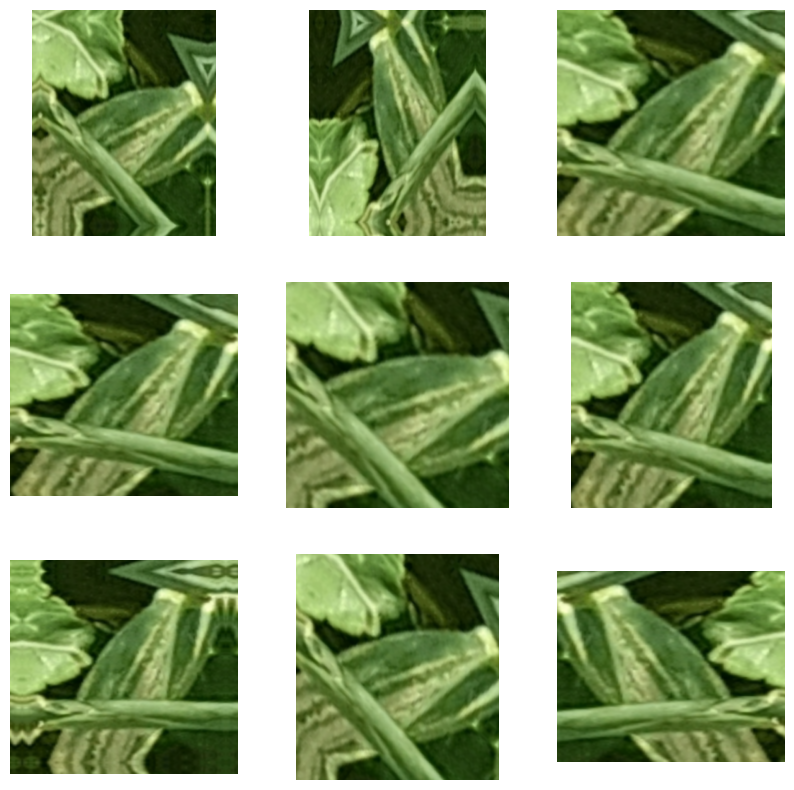

In [ ]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

**Brown RUST**

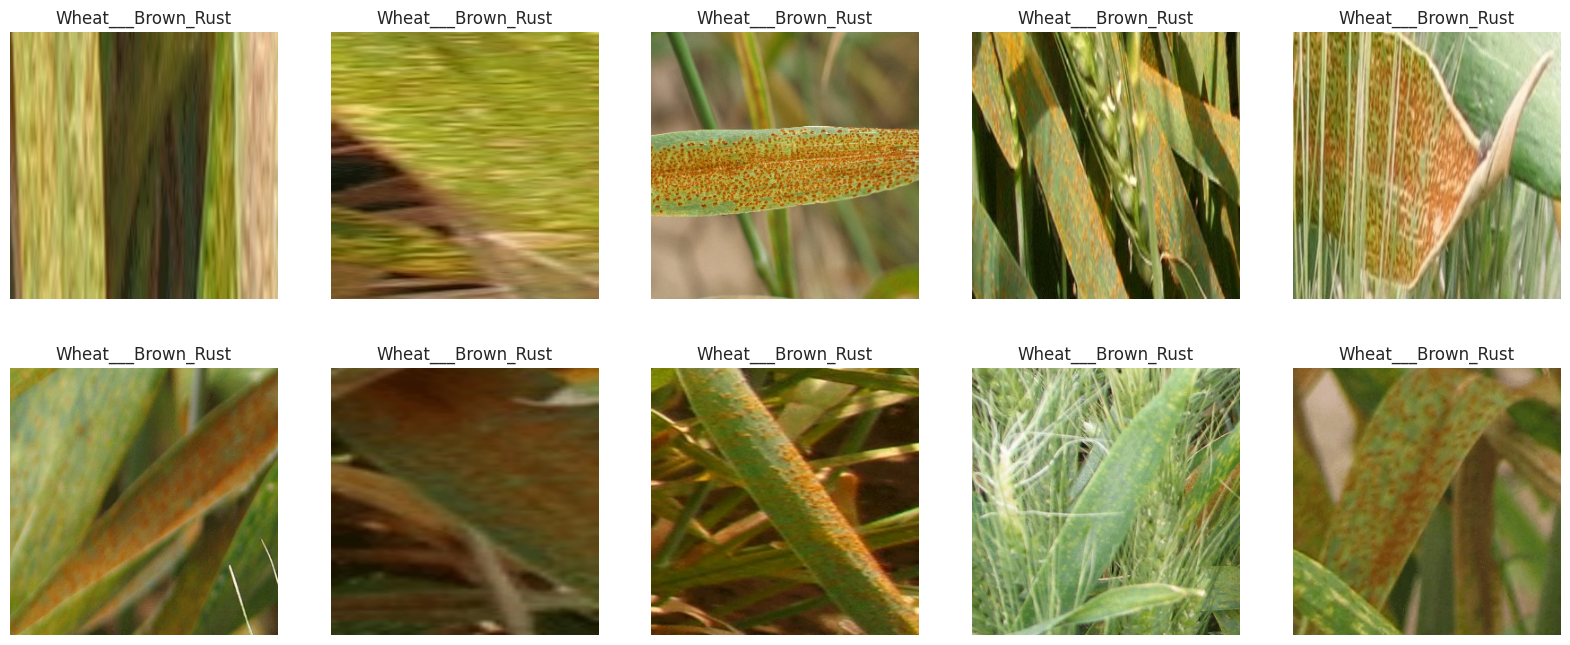

In [ ]:
plt.figure(figsize=(20,8))
Wheat___Brown_Rust = []
Wheat___Yellow_Rust = []

# Iterate through more batches to collect more samples
for images , labels in train_dataset.take(10): # Increased from take(1) to take(10)
    # Iterate through the actual number of labels in the batch
    for i in range(labels.shape[0]):
        if class_names[labels[i]] == "Wheat___Brown_Rust":
            Wheat___Brown_Rust.append(images[i].numpy().astype("uint8"))
        if  class_names[labels[i]] == "Wheat___Yellow_Rust":
            Wheat___Yellow_Rust.append(images[i].numpy().astype("uint8"))

# Display only the available images, up to 10
for i in range(min(10, len(Wheat___Brown_Rust))): # Changed to display up to 10 or the available images
    plt.subplot(2,5,i+1)
    plt.imshow(Wheat___Brown_Rust[i])
    plt.axis("off")
    plt.title("Wheat___Brown_Rust")

**BLACK ROT**

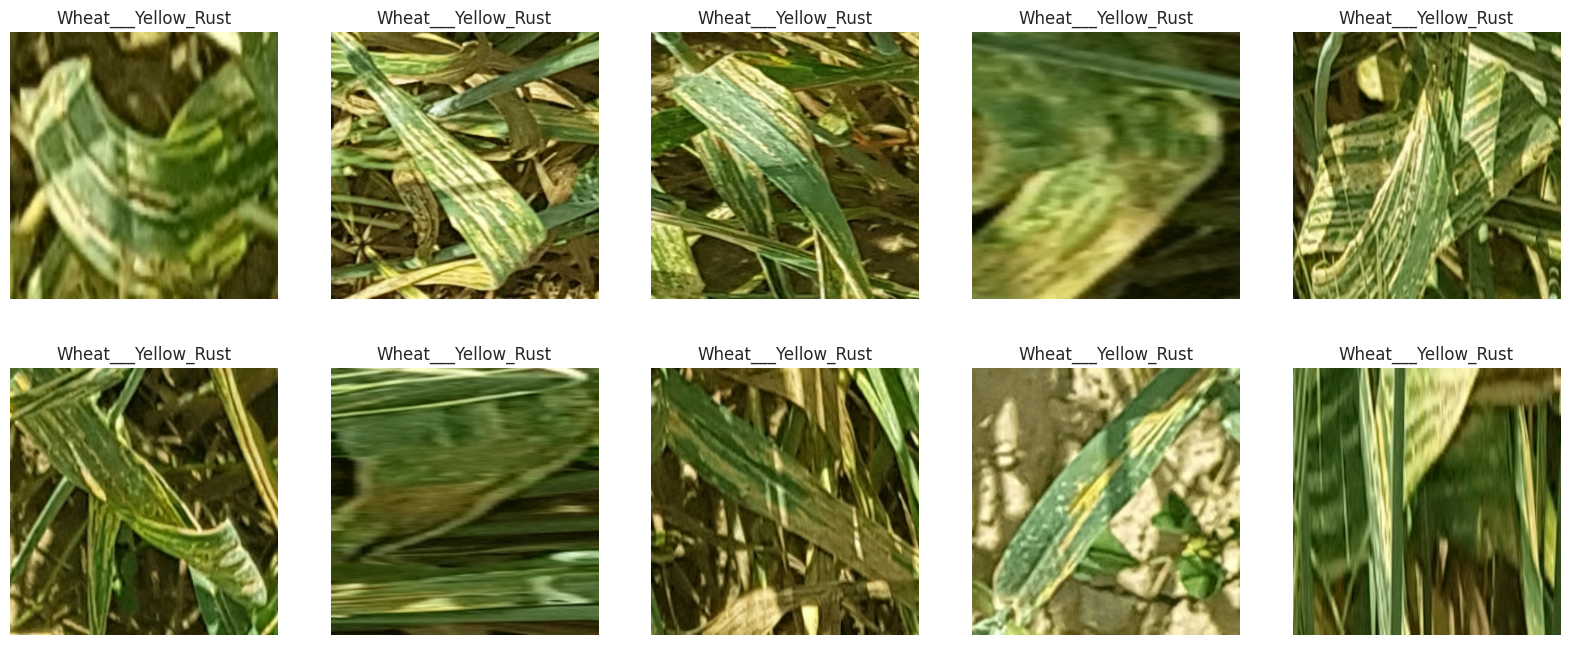

In [ ]:
plt.figure(figsize=(20,8))
for i in range(min(10, len(Wheat___Yellow_Rust))): # Changed to display up to 10 or the available images
    plt.subplot(2,5,i+1)
    plt.imshow(Wheat___Yellow_Rust[i])
    plt.axis("off")
    plt.title("Wheat___Yellow_Rust")

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

**MODELING**

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.DenseNet121(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')


29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
type(base_model)
preprocess_input = tf.keras.applications.densenet.preprocess_input


In [ ]:
nb_layers = len(base_model.layers)
print("Number of Layers =", nb_layers)
print(base_model.layers[-2].name)  # Pre-last layer name
print(base_model.layers[-1].name)  # Last layer name


Number of Layers = 427
bn
relu


In [ ]:
# Ensure base_model is a TensorFlow model and in inference mode
image_batch, label_batch = next(iter(train_dataset))  # Get a batch of images

# Run the base model on the batch to extract features
feature_batch = base_model(image_batch, training=False)

# Print the feature map shape
print("Feature batch shape:", feature_batch.shape)


Feature batch shape: (128, 9, 9, 1024)


**DenseNet 121**

In [ ]:
import tensorflow as tf

def plant_leaf_model(image_shape=IMG_SIZE):
    """Define a tf.keras model using DenseNet121 for multi-class classification."""
    image_shape = image_shape + (3,)  # Ensure input shape includes color channels

    # Load the DenseNet121 model (pretrained on ImageNet) without the top layer
    base_model = tf.keras.applications.DenseNet121(input_shape=image_shape, include_top=False, weights='imagenet')

    # Set all layers to trainable, but freeze the first few for transfer learning
    base_model.trainable = True
    for layer in base_model.layers[:300]:  # Freeze the first 300 layers
        layer.trainable = False

    # Define the model architecture
    inputs = tf.keras.Input(shape=image_shape)
    x = data_augmentation(inputs)  # Apply data augmentation
    x = preprocess_input(inputs)  # Apply preprocessing
    x = base_model(x, training=False)  # Extract features using DenseNet121
    x = tf.keras.layers.GlobalAveragePooling2D()(x)  # Global Average Pooling
    x = tf.keras.layers.Dropout(0.2)(x)  # Dropout for regularization
    prediction_layer = tf.keras.layers.Dense(4, activation="softmax")  # Output layer (4 classes)
    outputs = prediction_layer(x)

    # Create the final model
    model = tf.keras.Model(inputs, outputs)
    model.summary()

    return model


In [ ]:
Plant_Leaf_Model = plant_leaf_model(IMG_SIZE)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 299, 299, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 299, 299, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 299, 299, 3)      0         
 da)                                                             
                                                                 
 densenet121 (Functional)    (None, 9, 9, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0     

In [ ]:
# Set a lower base learning rate
base_learning_rate = 0.0001  # Suggested: 1e-4 or 1e-3

# Compile the model
Plant_Leaf_Model.compile(
    optimizer=tf.keras.optimizers.Nadam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)


In [ ]:
history = Plant_Leaf_Model.fit(train_dataset , verbose=2 , epochs=10 ,class_weight=class_weight,
                               validation_data=validation_dataset , use_multiprocessing= True)

Epoch 1/10
27/27 - 637s - loss: 0.4214 - accuracy: 0.7843 - val_loss: 0.0327 - val_accuracy: 0.9974 - 637s/epoch - 24s/step
Epoch 2/10
27/27 - 607s - loss: 0.0168 - accuracy: 0.9929 - val_loss: 0.0269 - val_accuracy: 0.9947 - 607s/epoch - 22s/step
Epoch 3/10
27/27 - 592s - loss: 0.0077 - accuracy: 0.9959 - val_loss: 0.0237 - val_accuracy: 0.9947 - 592s/epoch - 22s/step
Epoch 4/10
27/27 - 596s - loss: 0.0030 - accuracy: 0.9994 - val_loss: 0.0192 - val_accuracy: 0.9947 - 596s/epoch - 22s/step
Epoch 5/10
27/27 - 585s - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0067 - val_accuracy: 0.9974 - 585s/epoch - 22s/step
Epoch 6/10
27/27 - 624s - loss: 6.6998e-04 - accuracy: 1.0000 - val_loss: 0.0057 - val_accuracy: 0.9974 - 624s/epoch - 23s/step
Epoch 7/10
27/27 - 595s - loss: 4.9907e-04 - accuracy: 1.0000 - val_loss: 0.0212 - val_accuracy: 0.9947 - 595s/epoch - 22s/step
Epoch 8/10
27/27 - 624s - loss: 0.0042 - accuracy: 0.9985 - val_loss: 0.0145 - val_accuracy: 0.9947 - 624s/epoch - 23s/step


In [ ]:
Plant_Leaf_Model.evaluate(validation_dataset , verbose = 1)

3/3 [==============================] - 52s 17s/step - loss: 0.0143 - accuracy: 0.9974


[0.014275254681706429, 0.9973545074462891]

1/1 [==============================] - 0s 118ms/step


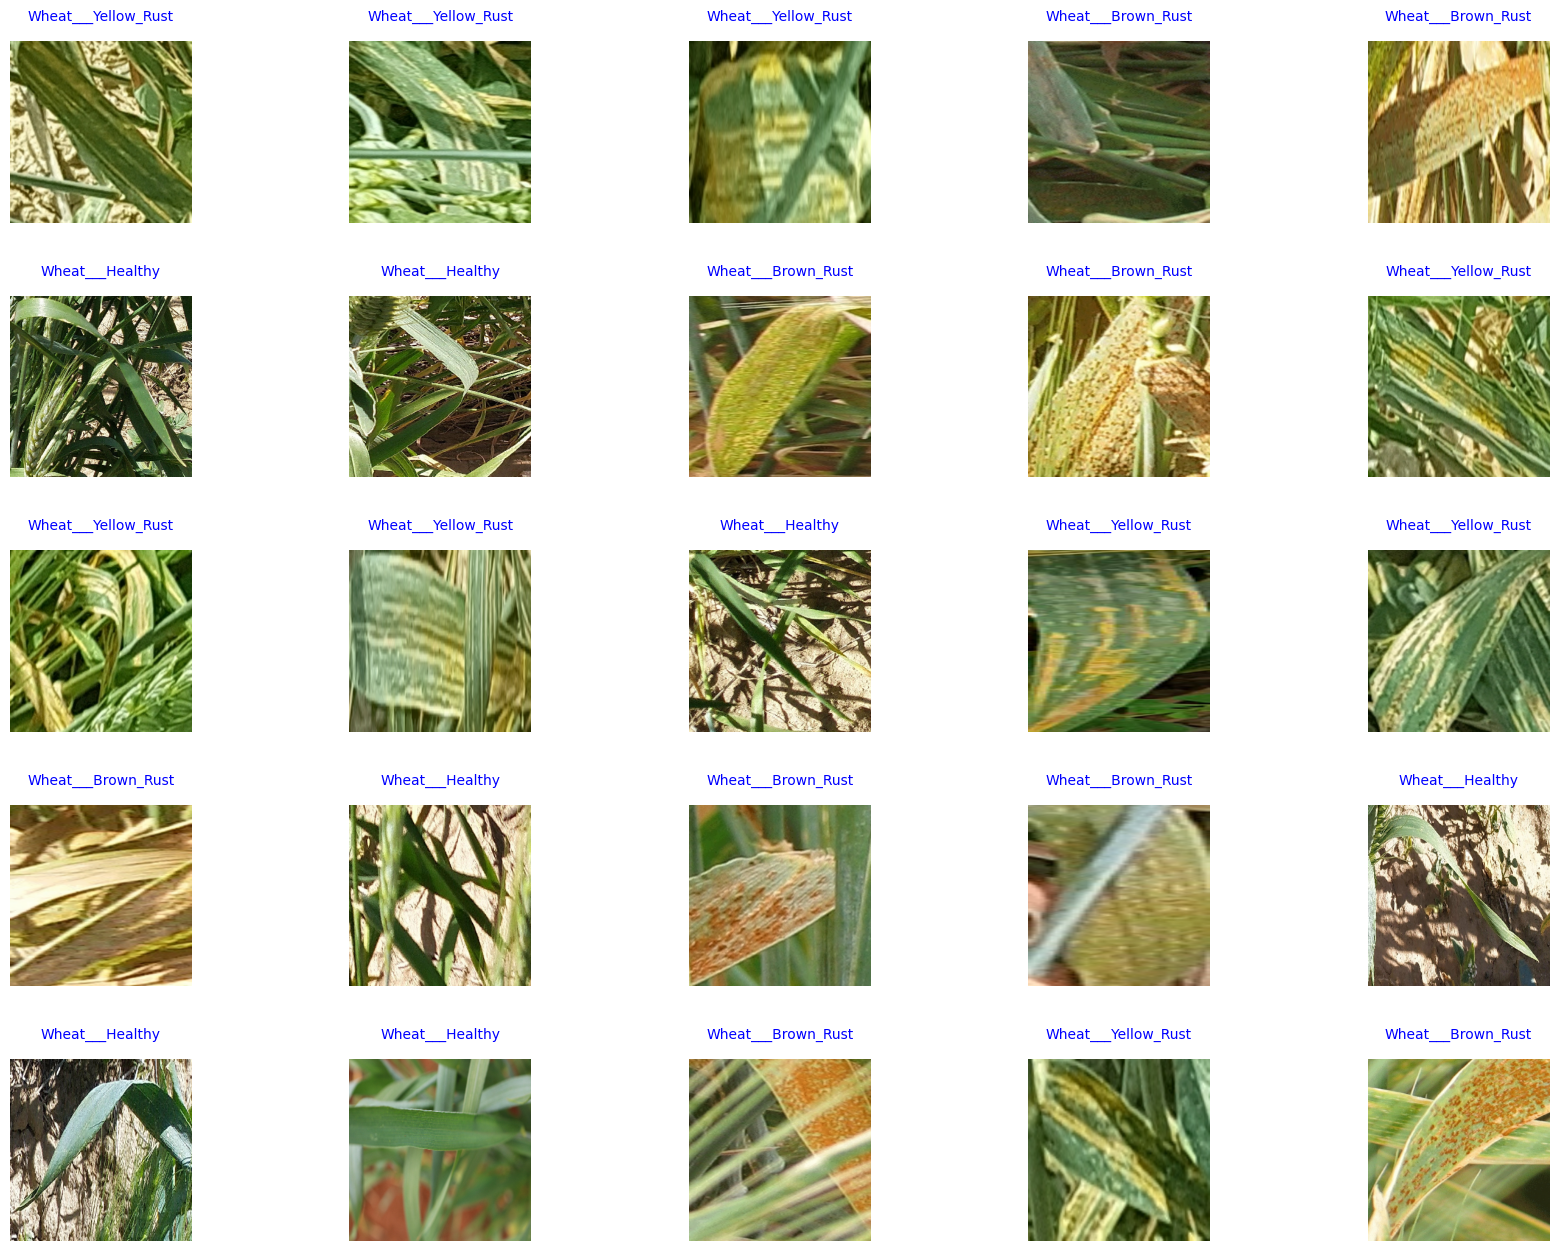

In [ ]:
plt.figure(figsize=(20, 15))
for images, labels in train_dataset.take(1):
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")
        im2 = images[i].numpy().astype("uint8")
        img2 = tf.expand_dims(im2, 0)
        predict = Plant_Leaf_Model.predict(img2)
        predicted= class_names[np.argmax(predict)]
        actual = class_names [labels[i].numpy().astype("uint8")]
        if (actual == predicted):
            plt.title(predicted, fontsize=10, color= 'blue', pad=15);
        else :
            plt.title(actual, fontsize=10, color= 'red' ,pad=15);
        plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9,
                            top=0.9, wspace=0.4,hspace=0.4)

**Plotting Accuracy**

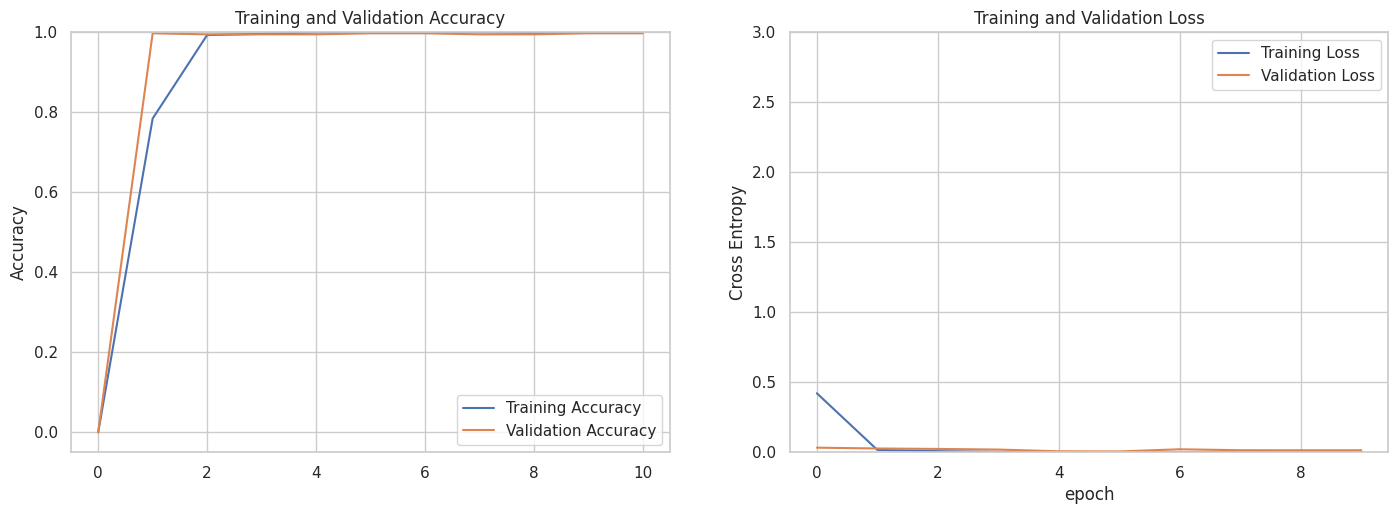

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(17, 12))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

4/4 [==============================] - 15s 3s/step


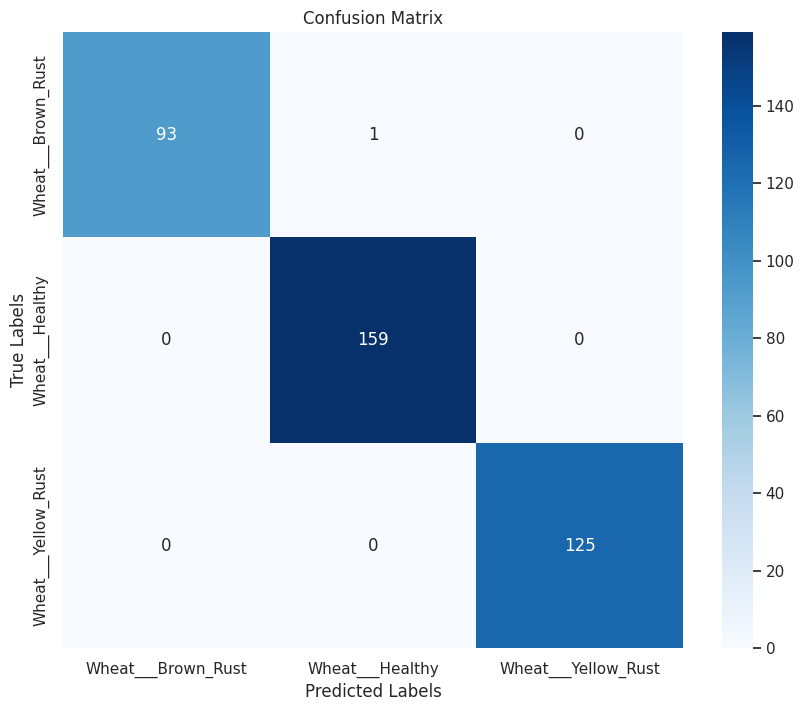

Confusion Matrix:
[[ 93   1   0]
 [  0 159   0]
 [  0   0 125]]


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Get the true labels and predicted labels
true_labels = []
predicted_labels = []

for images, labels in validation_dataset:
    predictions = Plant_Leaf_Model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_labels.extend(labels.numpy())
    predicted_labels.extend(predicted_classes)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print confusion matrix separately
print("Confusion Matrix:")
print(conf_matrix)



In [ ]:
# Print classification report separately
print("Classification Report:")
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print(report)

Classification Report:
                     precision    recall  f1-score   support

 Wheat___Brown_Rust       1.00      0.99      0.99        94
    Wheat___Healthy       0.99      1.00      1.00       159
Wheat___Yellow_Rust       1.00      1.00      1.00       125

           accuracy                           1.00       378
          macro avg       1.00      1.00      1.00       378
       weighted avg       1.00      1.00      1.00       378

